In [1]:
#Install cv2, sclite, mxnet, matplotlib, numpy, gluonnlp, pdf2image
import difflib
import math
import random
import string
import os
from pdf2image import convert_from_path
random.seed(123)

import gluonnlp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf
from utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from tqdm import tqdm
from utils.expand_bounding_box import expand_bounding_box
from utils.sclite_helper import Sclite_helper
from utils.word_to_line import sort_bbs_line_by_line, crop_line_images

from paragraph_segmentation_dcnn import make_cnn as ParagraphSegmentationNet, paragraph_segmentation_transform
from word_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

ctx = mx.cpu(0)

In [2]:
MAX_IMAGE_SIZE_FORM = (1120, 800)
MAX_IMAGE_SIZE_LINE = (60, 800)
MAX_IMAGE_SIZE_WORD = (30, 140)

#test image as arg
file_path = "sample/test.jpg"
filename, file_ext = os.path.splitext(file_path)
if file_ext == '.pdf':
    images = convert_from_path(file_path, 500) #PIL image list
    for image in images:
        image.save(filename+'.jpg', 'JPEG')
    #numpy_images = []
    #for image in images:
        #numpy_images.append(np.asarray(image))

(3542, 2479)


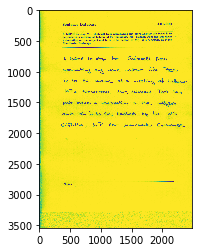

In [3]:
from skimage import color
from skimage import io

try:
    img = color.rgb2gray(io.imread(filename+'.png'))
except:
    img = color.rgb2gray(io.imread(filename+'.jpg'))

image = np.array(img)
print (image.shape)
# image = np.array(image)
# image = np.asarray(image)
plt.imshow(image)

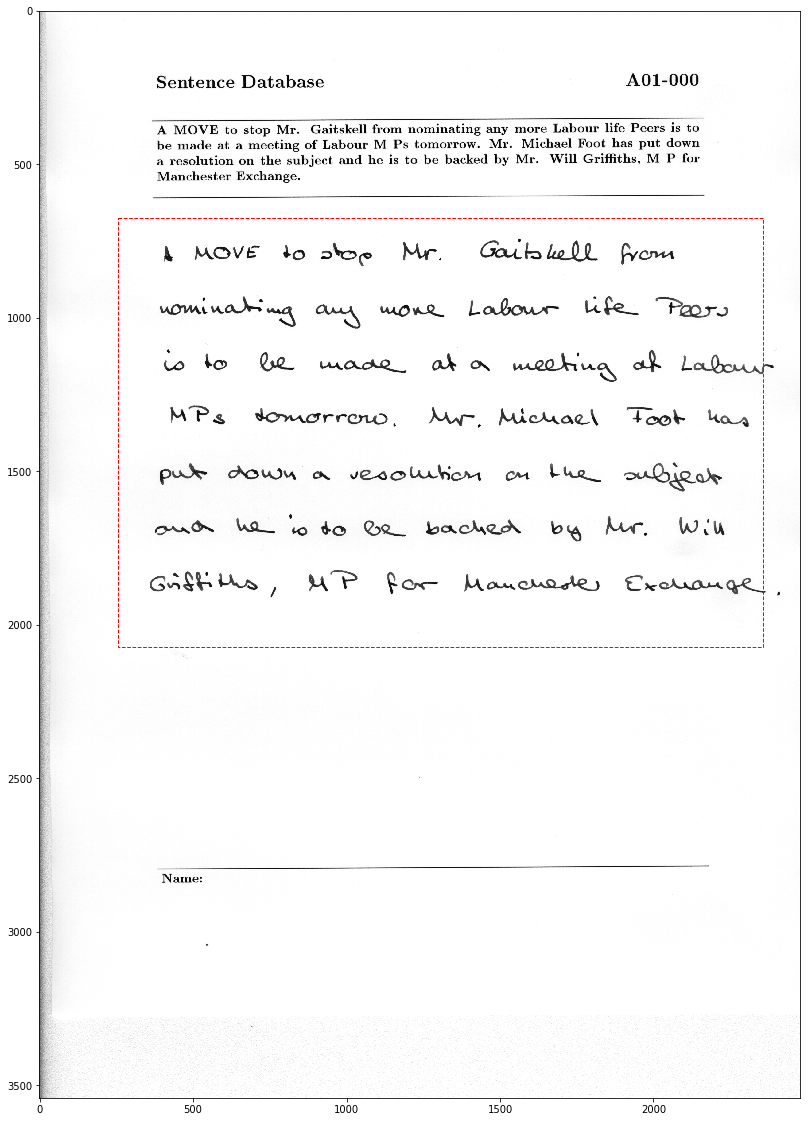

(0.1033385962247848, 0.19087253376841545, 0.8474203258752824, 0.3947216299176216)


In [4]:
paragraph_segmentation_net = ParagraphSegmentationNet()
paragraph_segmentation_net.load_parameters("../models/paragraph_segmentation2.params")

predicted_bbs = []

resized_image = paragraph_segmentation_transform(image, MAX_IMAGE_SIZE_FORM)
bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
bb_predicted = bb_predicted[0].asnumpy()
bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.05, expand_bb_scale_y=0.07)


fig,ax = plt.subplots(1, figsize=[20,20])
ax.imshow(image, cmap='Greys_r')

(x, y, w, h) = bb_predicted
image_h, image_w = image.shape[-2:]
(x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
ax.add_patch(rect)
ax.axis('on')
plt.show()
print(bb_predicted)

In [5]:
segmented_paragraph_size = (700, 700)

bb = bb_predicted
paragraph_segmented_image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)

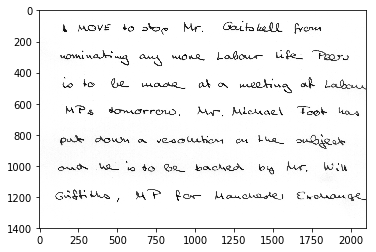

In [9]:
(x, y, w, h) = bb
x = x * image.shape[1]
y = y * image.shape[0]
w = w * image.shape[1]
h = h * image.shape[0]
(x1, y1, x2, y2) = (x, y, x + w, y + h)
(x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
image2 = image[y1:y2, x1:x2]
image21, _ = resize_image(image2, desired_size=segmented_paragraph_size)
plt.imshow(image2, cmap='Greys_r')

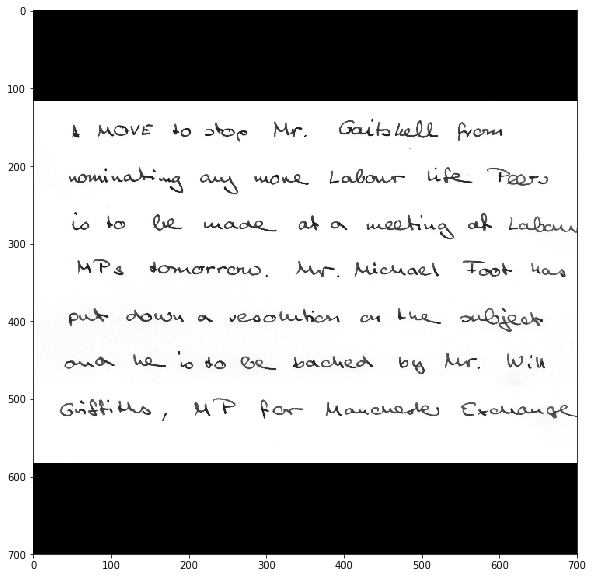

In [10]:
import cv2
desired_size = segmented_paragraph_size
size = image2.shape[:2]
if size[0] > desired_size[0] or size[1] > desired_size[1]:
    ratio_w = float(desired_size[0])/size[0]
    ratio_h = float(desired_size[1])/size[1]
    ratio = min(ratio_w, ratio_h)
    new_size = tuple([int(x*ratio) for x in size])
    image21 = cv2.resize(image2, (new_size[1], new_size[0]))
    size = image21.shape

delta_w = max(0, desired_size[1] - size[1])
delta_h = max(0, desired_size[0] - size[0])
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)
color = image[0][0]
if color < 230:
    color = 1
image21 = cv2.copyMakeBorder(image21, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
# crop_bb = (left/image.shape[1], top/image.shape[0], (image.shape[1] - right - left)/image.shape[1],
#            (image.shape[0] - bottom - top)/image.shape[0])
# image[image > 230] = 255
plt.figure(figsize=[10,10])
plt.imshow(image21, cmap='Greys_r')

(-0.5, 699.5, 699.5, -0.5)

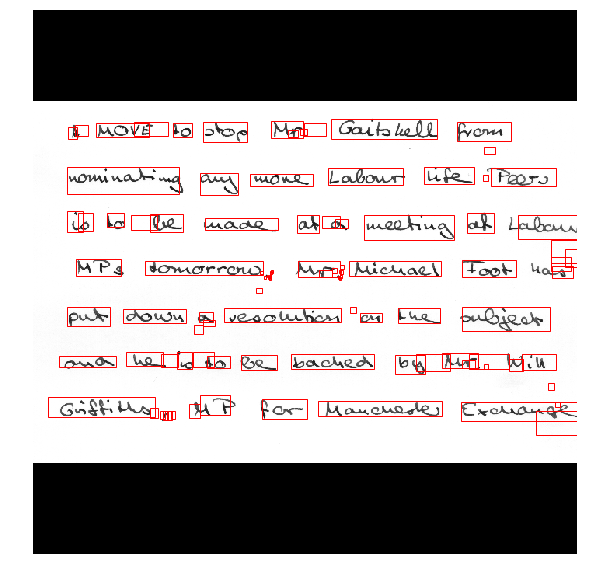

In [11]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("../models/word_segmentation2.params")
min_c = 0.001

overlap_thres = 0.2
topk = 600


fig, axs = plt.subplots(1,1,figsize=(10, 10 ))
predicted_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

axs.imshow(image21, cmap='Greys_r')
for j in range(predicted_bb.shape[0]):     
    (x, y, w, h) = predicted_bb[j]
    image_h, image_w = paragraph_segmented_image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs.add_patch(rect)
    axs.axis('off')


axs.imshow(image21, cmap='Greys_r')
axs.axis('off')


In [12]:
line_bbs = sort_bbs_line_by_line(predicted_bb, y_overlap=0.4)
line_images = crop_line_images(paragraph_segmented_image, line_bbs)

axs.imshow(image21, cmap='Greys_r')
axs.axis('off')

for line_bb in line_bbs:
    (x, y, w, h) = line_bb
    image_h, image_w = paragraph_segmented_image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs.add_patch(rect)

In [13]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512, rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("../models/handwriting_line_sl_160_a_512_o_2.params")

In [14]:
line_image_size = (60, 800)
form_character_prob = []
for i, line_image in enumerate(line_images):
    line_image = handwriting_recognition_transform(line_image, line_image_size)
    line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
    form_character_prob.append(line_character_prob)

In [17]:
from utils.CTCDecoder.BeamSearch import ctcBeamSearch
from utils.CTCDecoder.LanguageModel import LanguageModel

def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

def get_beam_search(prob, width=20, k=4):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width, k)
    return possibilities[0]

def get_beam_search_with_lm(prob, width=20, k=4):
    lm = LanguageModel('utils/alicewonder.txt', alphabet_encoding)
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, lm, width, k)
    return possibilities[0]

(-0.5, 799.5, 59.5, -0.5)

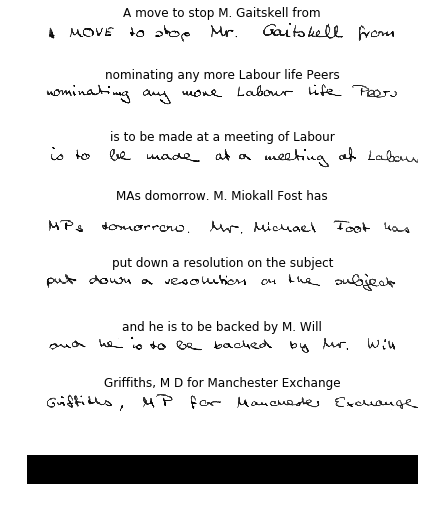

In [18]:
fig, axs = plt.subplots(len(form_character_prob) + 1, figsize=(7, int(1 + 1.2 * len(form_character_prob))))
for j, line_character_probs in enumerate(form_character_prob):
    decoded_line = get_beam_search_with_lm(line_character_probs)
    line_image = line_images[j]
    axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
    axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
    axs[j].set_title("{}".format(decoded_line))
    axs[j].axis('off')
axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
axs[-1].axis('off')

In [19]:
from new import recognizer